Importing Libraries

In [59]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Defining Transformations:
Normalizing the image to make training stable as raw image pixels are in range(0-255)

In [61]:
# For Training: Augmentation (helps to prevent overfitting) + Normalization
trainTransforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), # Convert to Tensor (Pytorch uses tensor to store data for model.)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For test and validation:
valTransforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Loding the Dataset

In [62]:
# change the root to your respective dataset path
dataset = datasets.ImageFolder(root="D:/cell_images", transform=trainTransforms)

Spliting the data into Train and Validation (80%-20%)

In [63]:
trainSize = int(0.7*len(dataset))
valSize = int(0.15*len(dataset))
testSize = len(dataset)-trainSize-valSize

trainDataset, valDataset, testDataset = random_split(dataset, [trainSize, valSize, testSize])

trainDataset.dataset.transform = trainTransforms
valDataset.dataset.transform = valTransforms
testDataset.dataset.transform = valTransforms

Creating a DataLoaders

In [64]:
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=20, shuffle=False)

dataLoaders = {
    'train' : trainLoader,
    'valid' : valLoader,
    'test' : testLoader
}

Inverse transform to undo the normalization to make image looks natural again when plotted with matplotlib

In [65]:
invTransform = transforms.Compose([
        transforms.Normalize(mean=[ 0., 0., 0. ],std=[ 1/0.229, 1/0.224, 1/0.225 ]), 
        transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ], std=[ 1., 1., 1. ])
    ])

# this functions show image tensor
def showImg(image):
    image = invTransform(image)
    image = image.numpy()
    image = np.transpose(image, (1,2,0)) # Rearranging the dimesion from [C,H,W] to [H,W,C]
    
    plt.imshow(image)
    plt.axis('off')

Ploting the image with matplotlib

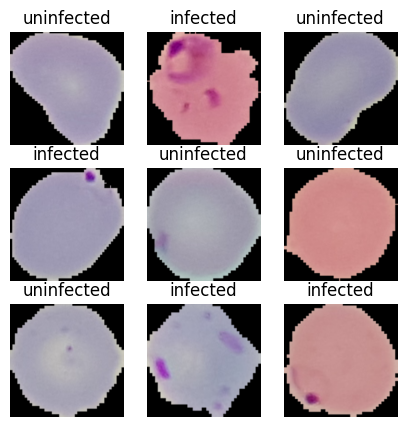

In [66]:
classes=['infected', 'uninfected']

# Getting a batch of training data
dataiter = iter(trainLoader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(5,5))

# Displaying 9 images
for idx in range(9):
    ax = fig.add_subplot(3, 3, idx+1)
    showImg(images[idx])
    ax.set_title(classes[labels[idx].item()])

Defining a CNN architecture

In [67]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        
        # Used to extract features from the image and the output is a 3d feature map
        self.conv = nn.Sequential(
            nn.Conv2d(3,16,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # It take those extracted fetures and decide what class the image belongs to. It performs classification based on the features learned by convolutional layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*64, 500),
            nn.ReLU(),
            nn.Dropout(0.2), # It randomly sets 20% of neurons to 0 to prevent overfitting
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 2)
        )
    
    # define how data flows through the network
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

modelScratch = net()
modelScratch.to(device)

net(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=100, out_features=2, bias=True)
  )
)

Defining a loss function

In [68]:
criterionScratch = nn.CrossEntropyLoss()

optimizerScratch = optim.Adam(modelScratch.parameters(), lr=0.001)